## Parâmetros de treinamento

* **Função de ativação:** `tanh`
* **Arquitetura:** 1–64–1

  * Entrada: coordenada x
  * Camada oculta: 64 neurônios (`tanh`)
  * Saída: deslocamento u(x)
* **Inicialização:** PyTorch default (reprodutível via seed aleatória registrada)
* **Seed:** gerada automaticamente no início da execução e impressa para reprodutibilidade

---

## Estratégia de testes

Foram avaliadas **18 combinações**:

* **Otimizadores:** Adam e L-BFGS
* **Taxas de aprendizado:** 1e-1, 1e-2, 1e-5
* **Épocas:** 40, 400, 1000

Para cada combinação, mediu-se:

* **Tempo de treino**
* **Loss final** (total, PDE e BC)
* **Convergência**:
  Considerada **"sim"** quando houve:

  1. **Queda suficiente** do loss em relação ao valor inicial (acima de um fator mínimo definido);
  2. **Estabilização (plateau)** indicada por inclinação média (`slope`) baixa no trecho final do treino.

---

## Critérios de convergência

* **Queda suficiente:** fator de redução > 10×
  (Ex.: perda inicial 1.0 → perda final < 0.1)
* **Plateau:** |slope| < 1e-3 no trecho final

**Motivos para “não convergiu”:**

* `queda insuficiente (N.x×)` → perda final não caiu o bastante
* `sem plateau` → perda ainda variando muito no fim
* `queda insuficiente + sem plateau` → ambas as condições não atendidas

---

## Resultados principais para a Seed 1834281386

| Padrão observado       | Explicação                                                                      |
| ---------------------- | ------------------------------------------------------------------------------- |
| **Adam com lr=1e-1**   | Rápida queda inicial, converge para 400+ épocas. Em 40 épocas, não estabiliza.  |
| **Adam com lr=1e-2**   | Queda mais lenta, precisa de mais épocas; não atinge plateau para 1000 épocas.  |
| **Adam com lr=1e-5**   | Praticamente não reduz a perda em nenhum cenário.                               |
| **L-BFGS com lr=1e-1** | Excelente convergência em 400 e 1000 épocas; muito rápido para estabilizar.     |
| **L-BFGS com lr=1e-2** | Não estabiliza no início (40 épocas), mas converge muito bem em 1000 épocas.    |
| **L-BFGS com lr=1e-5** | Muito lento; não atinge nem queda suficiente nem plateau, mesmo em 1000 épocas. |

---

## Comentários

* **L-BFGS** mostrou-se mais eficiente para queda expressiva de loss em menos épocas, mas muito sensível ao `lr`. Taxas muito baixas resultaram em custo computacional alto e pouca redução.
* **Adam** apresentou comportamento estável com `lr=1e-1` e `1e-2`, mas sem plateau para `1e-2` em 1000 épocas e queda insuficiente para `1e-5`.
* Em **40 épocas**, somente os casos com alto `lr` (e otimizador adequado) conseguiram redução significativa.
* Os tempos de execução variaram drasticamente: casos com L-BFGS e muitas épocas chegaram a \~16 segundos, enquanto Adam com poucas épocas e `lr` alto executou em menos de 0,05 s.

[Observação] Seed usada neste experimento: 1834281386


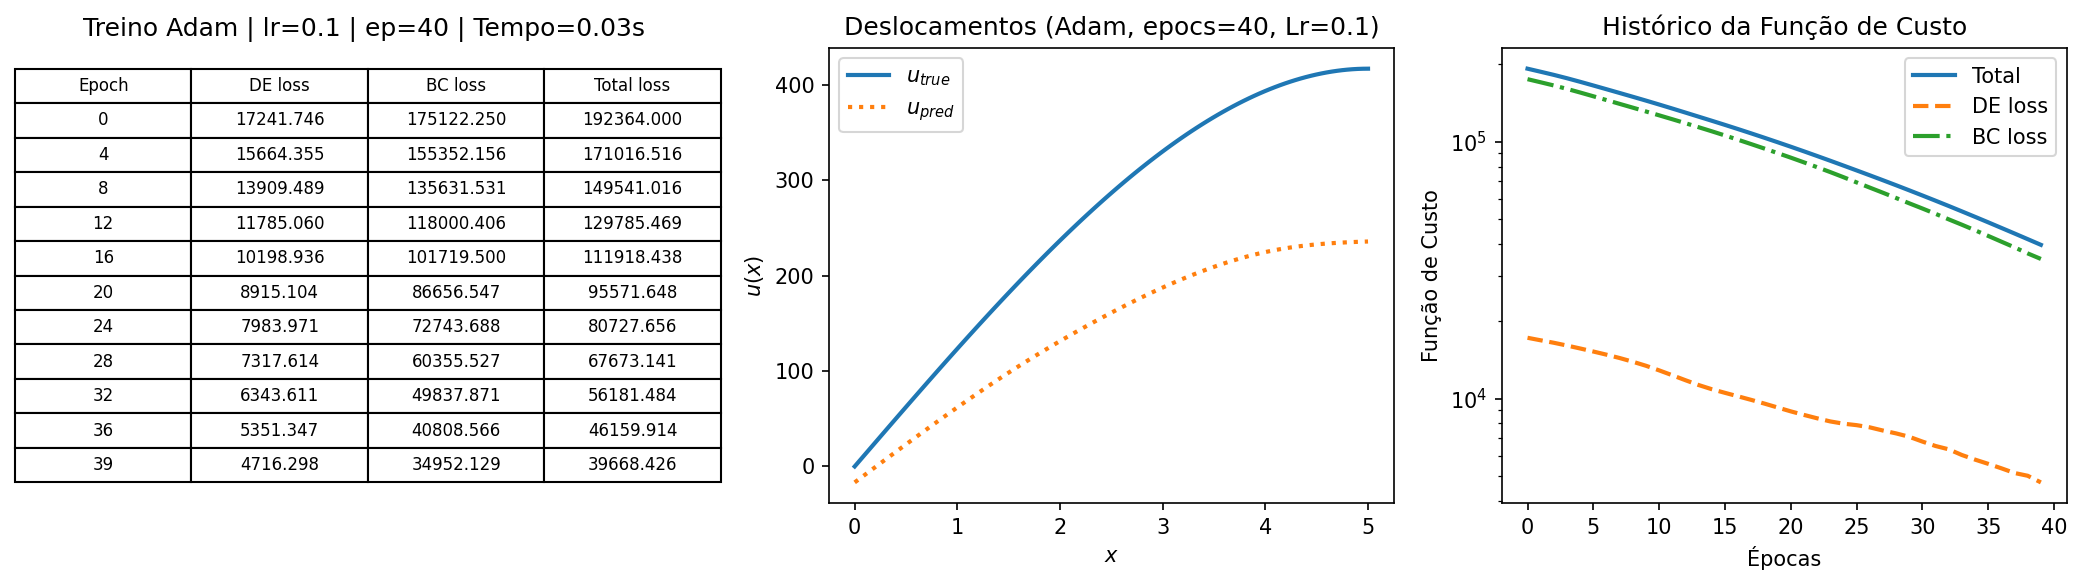

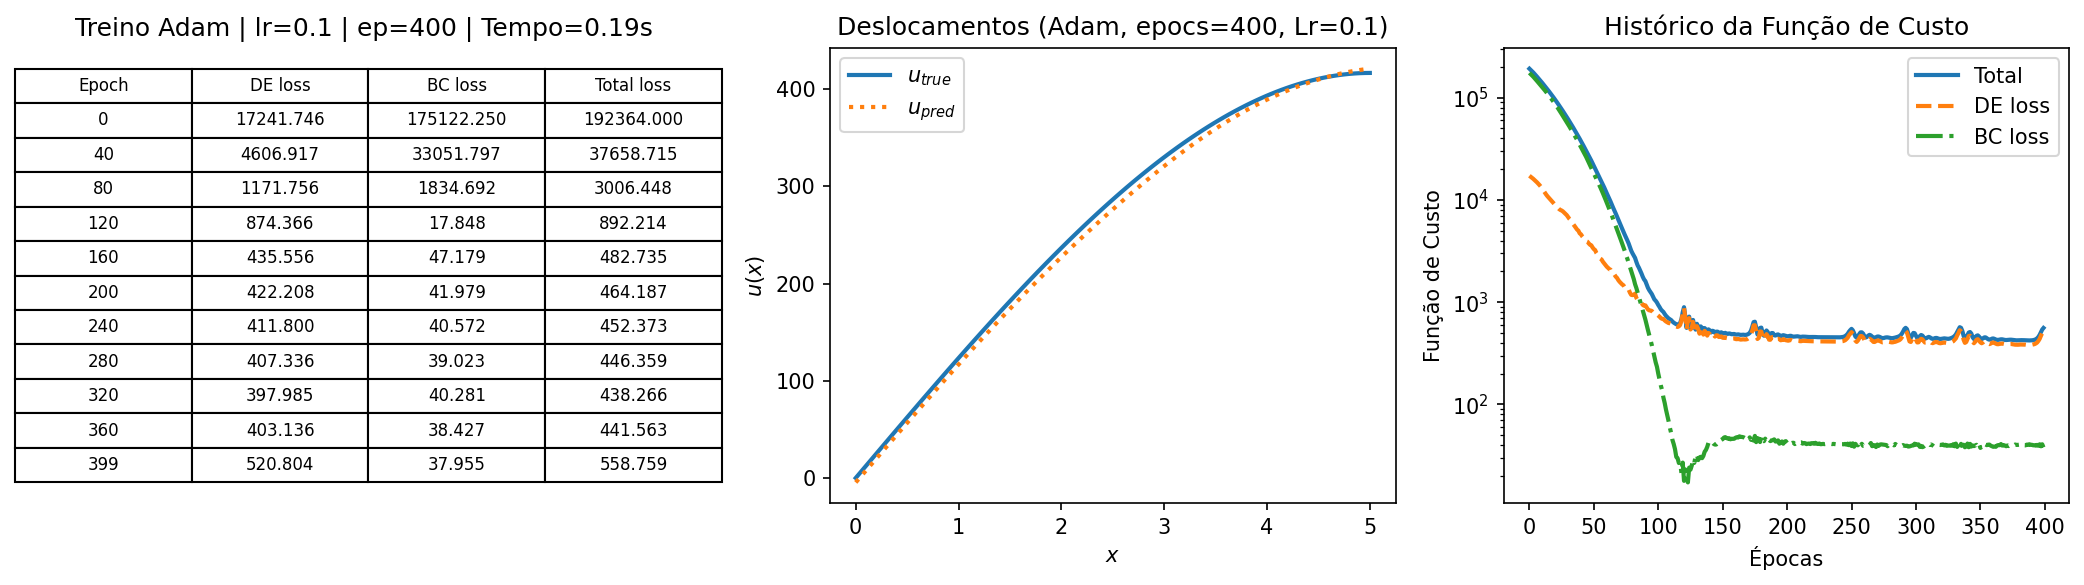

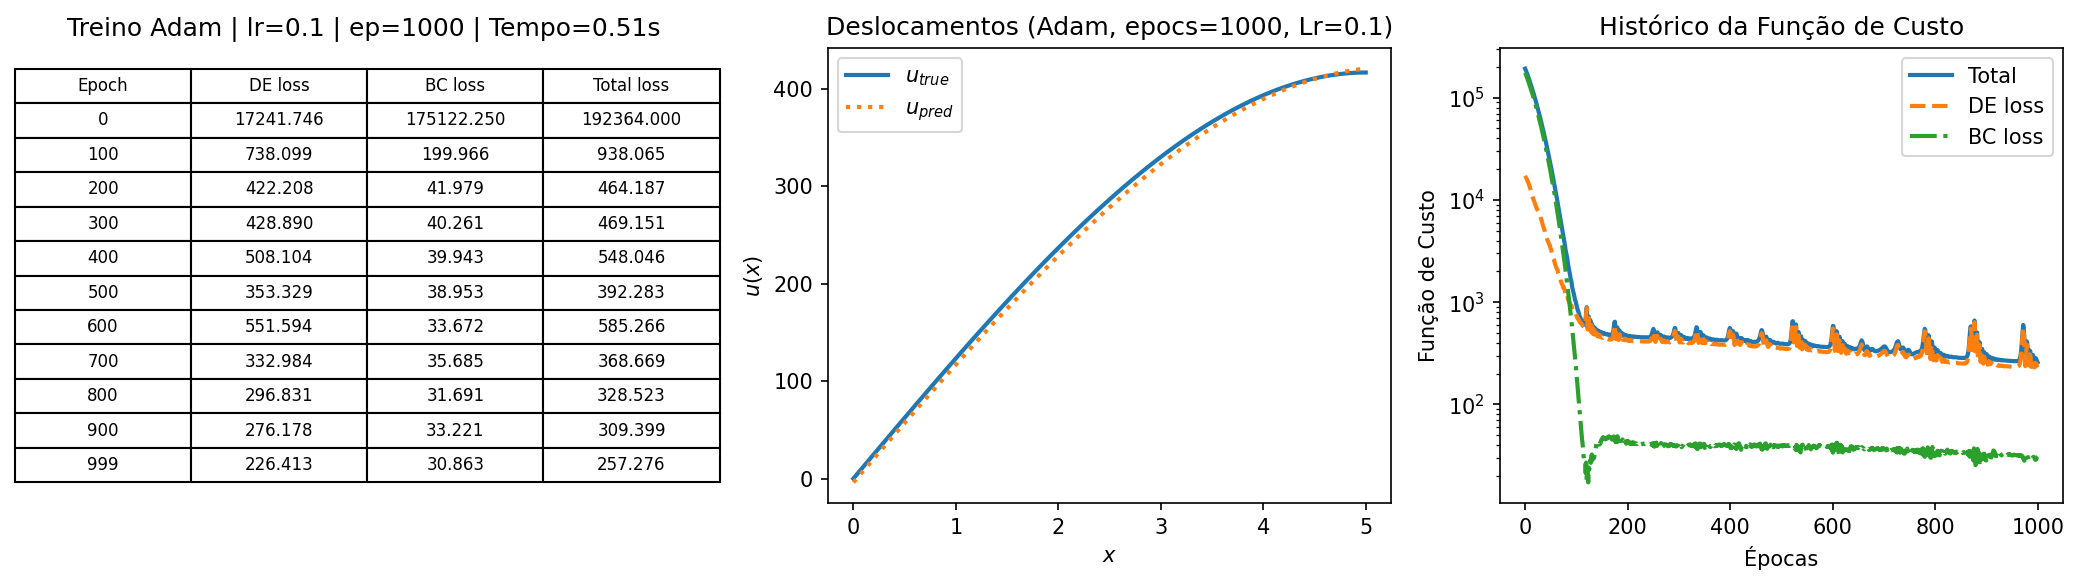

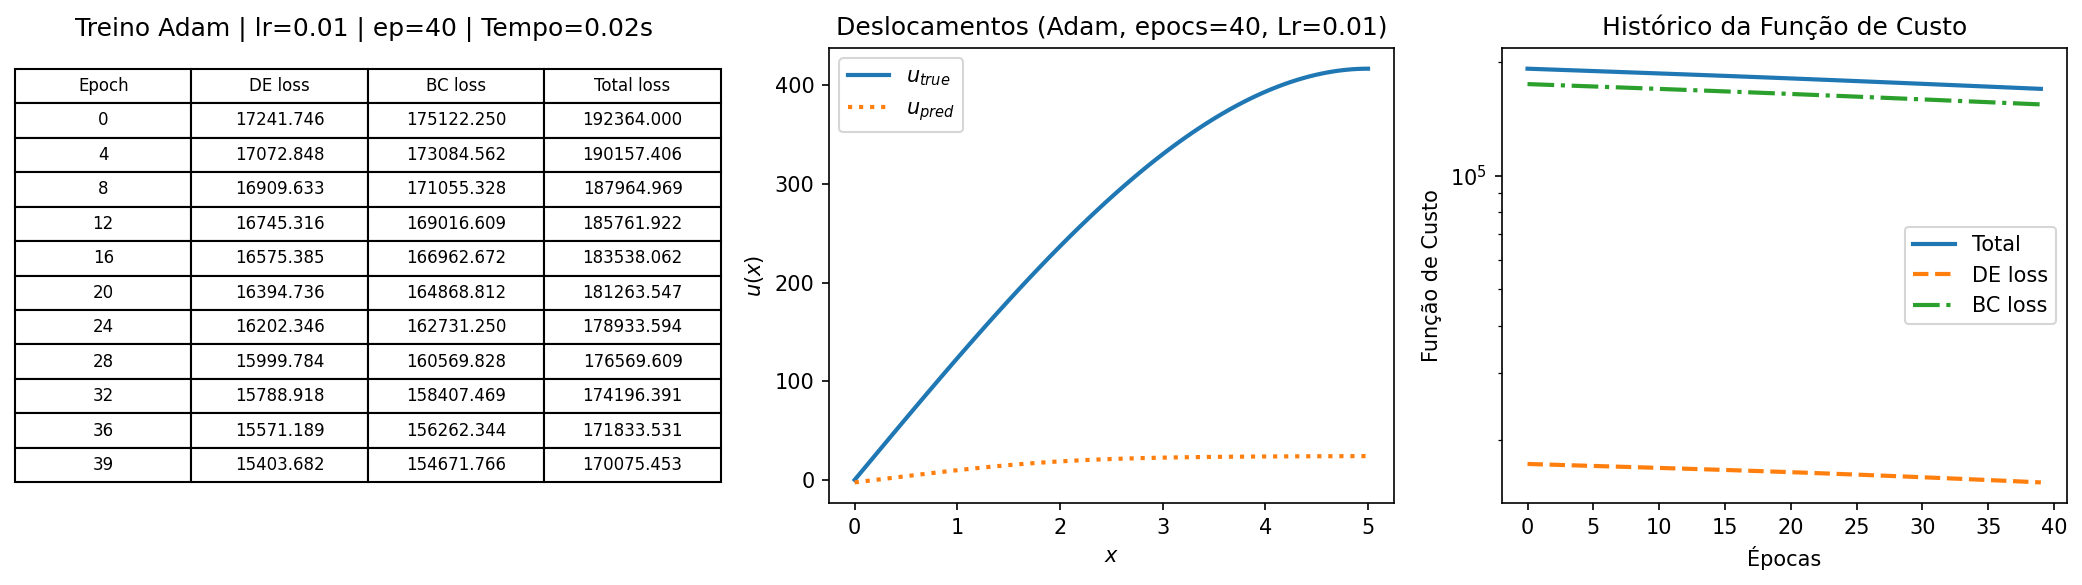

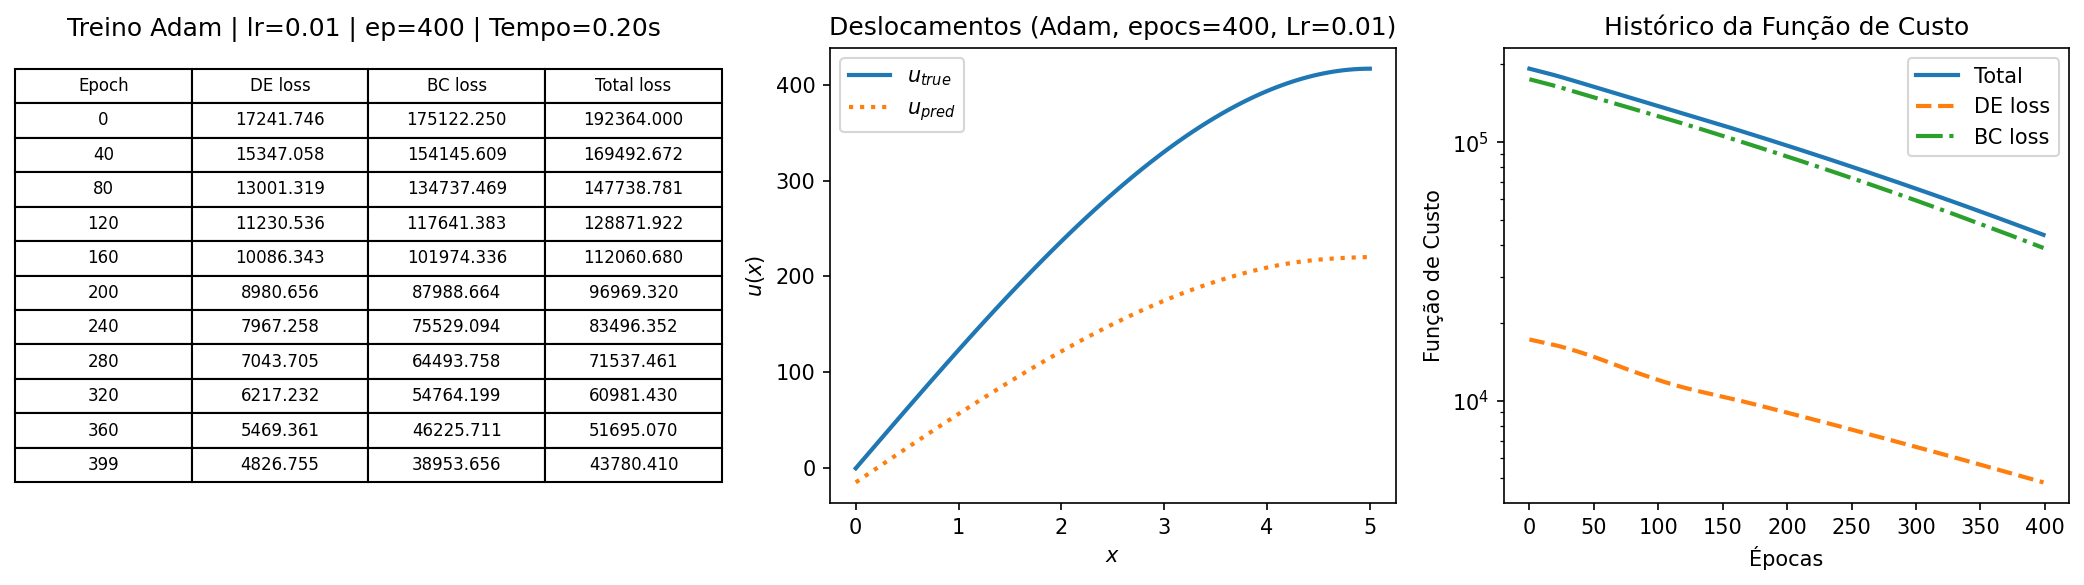

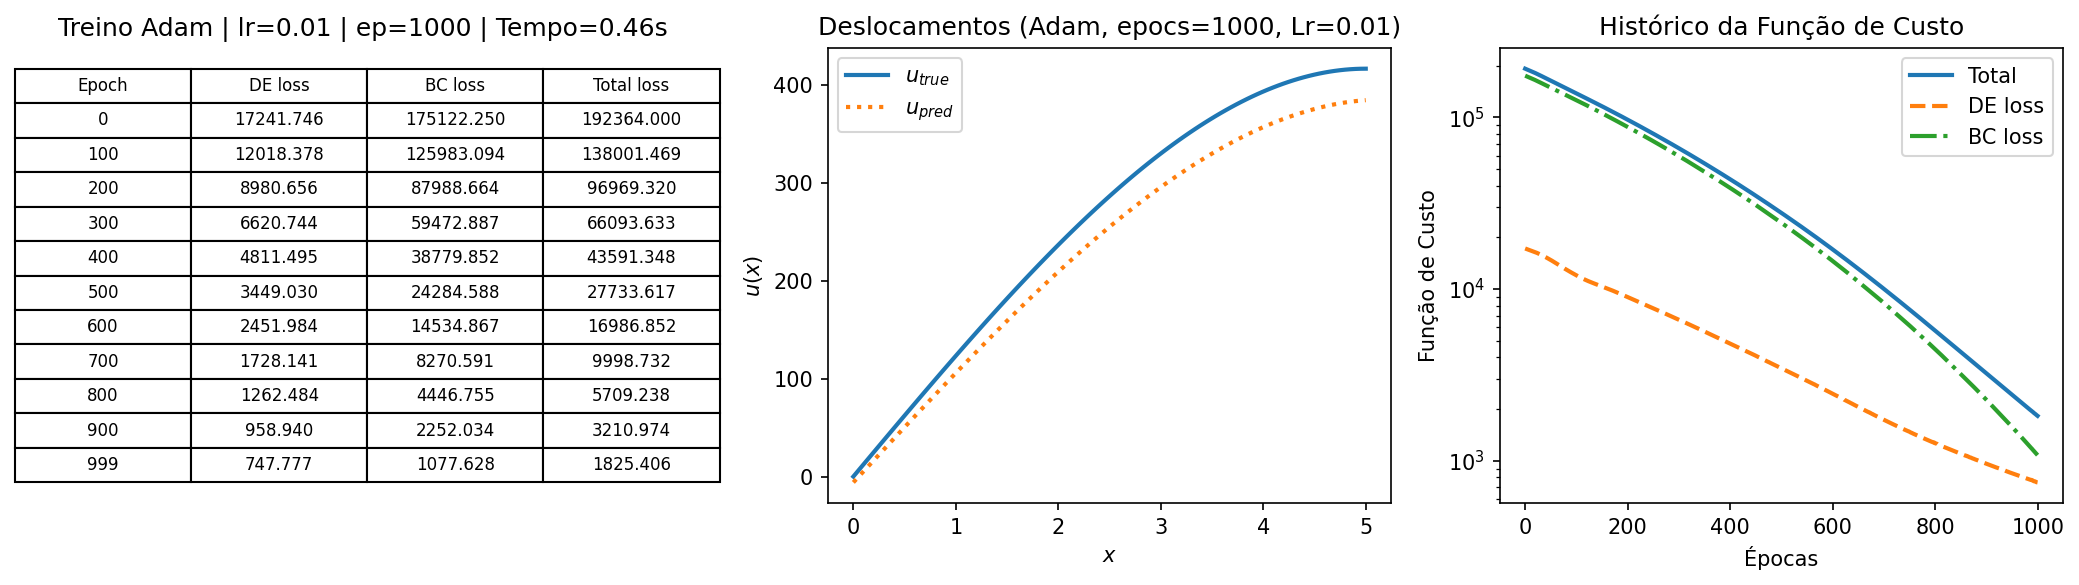

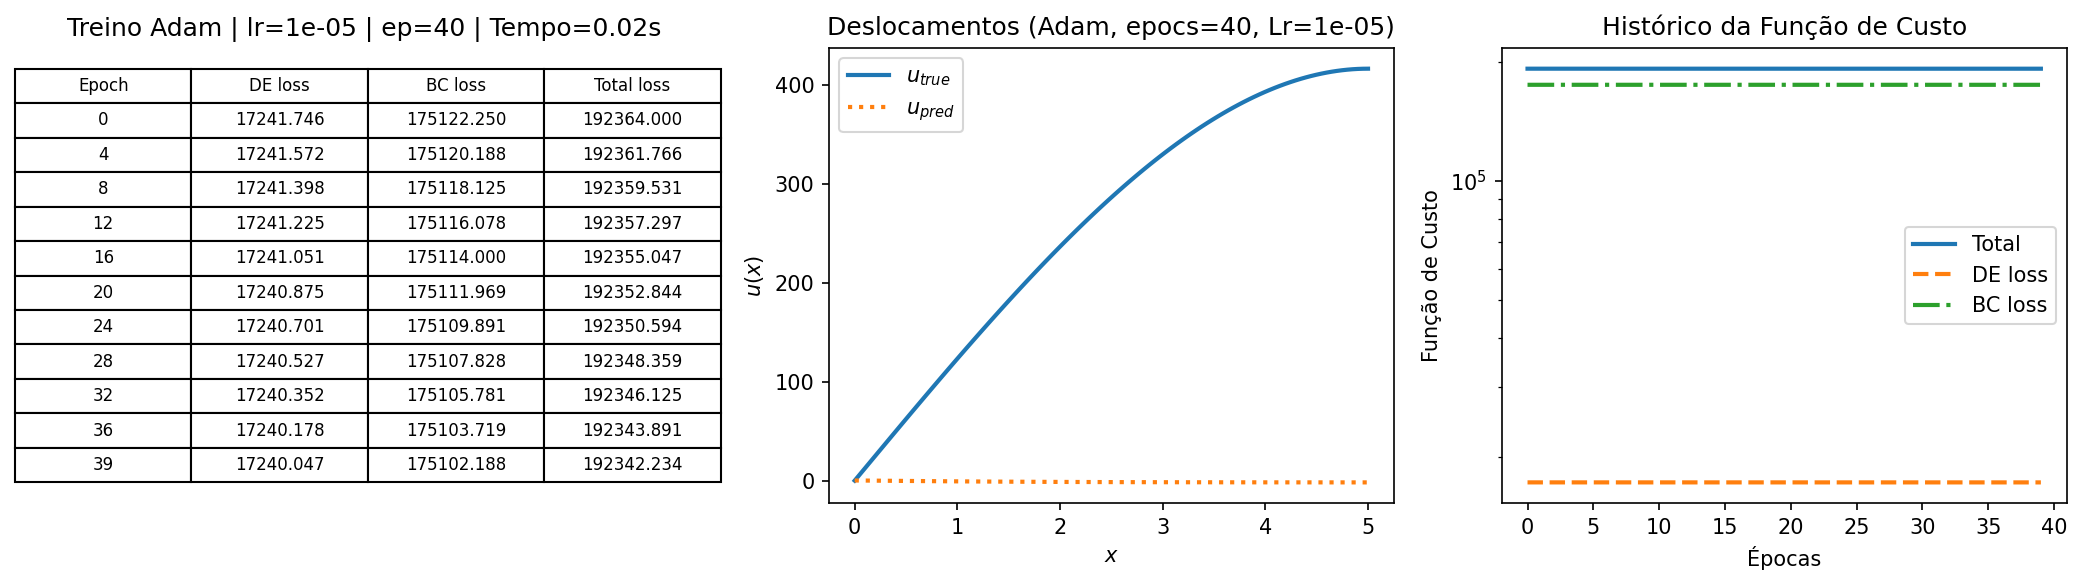

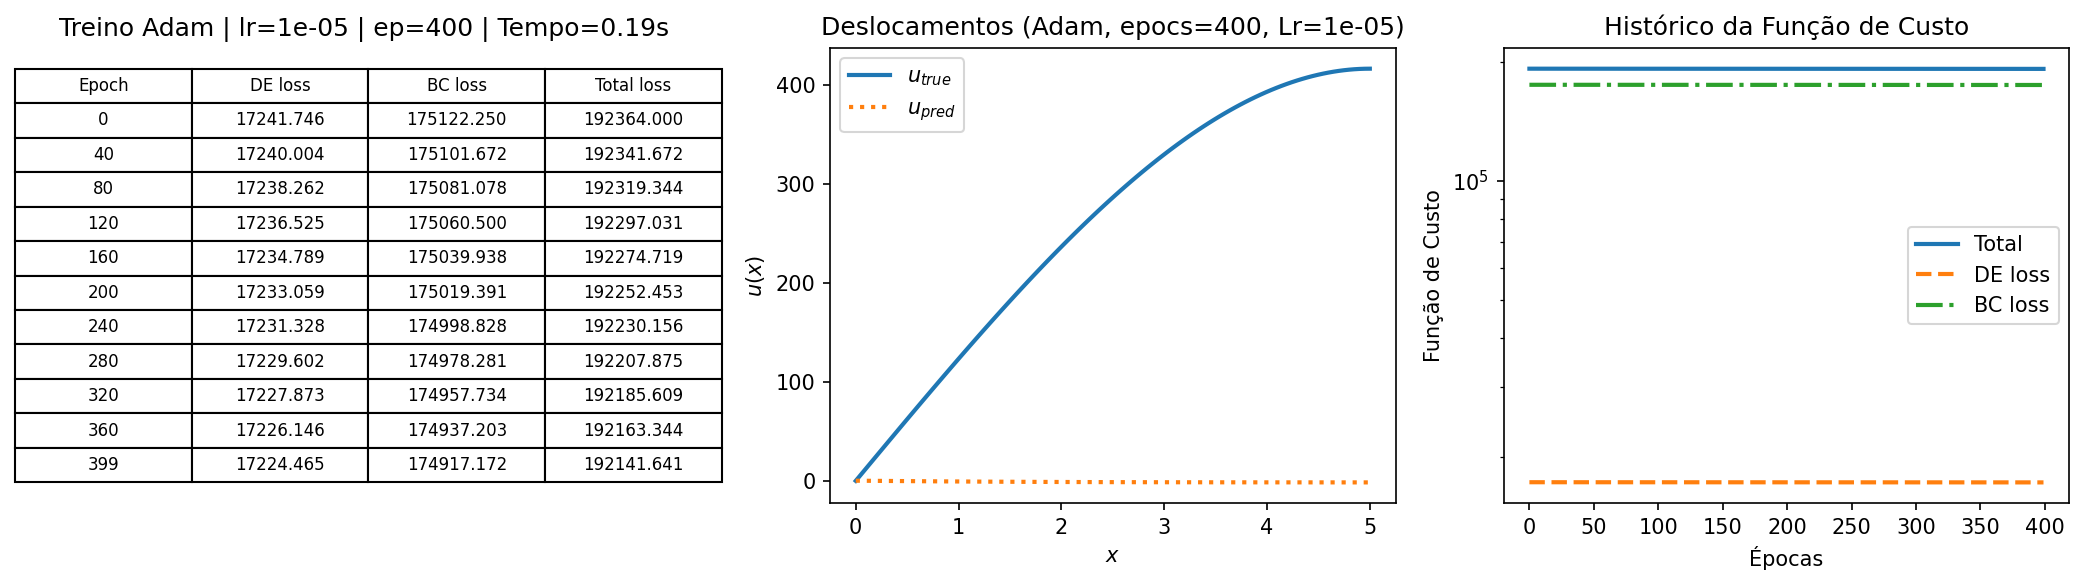

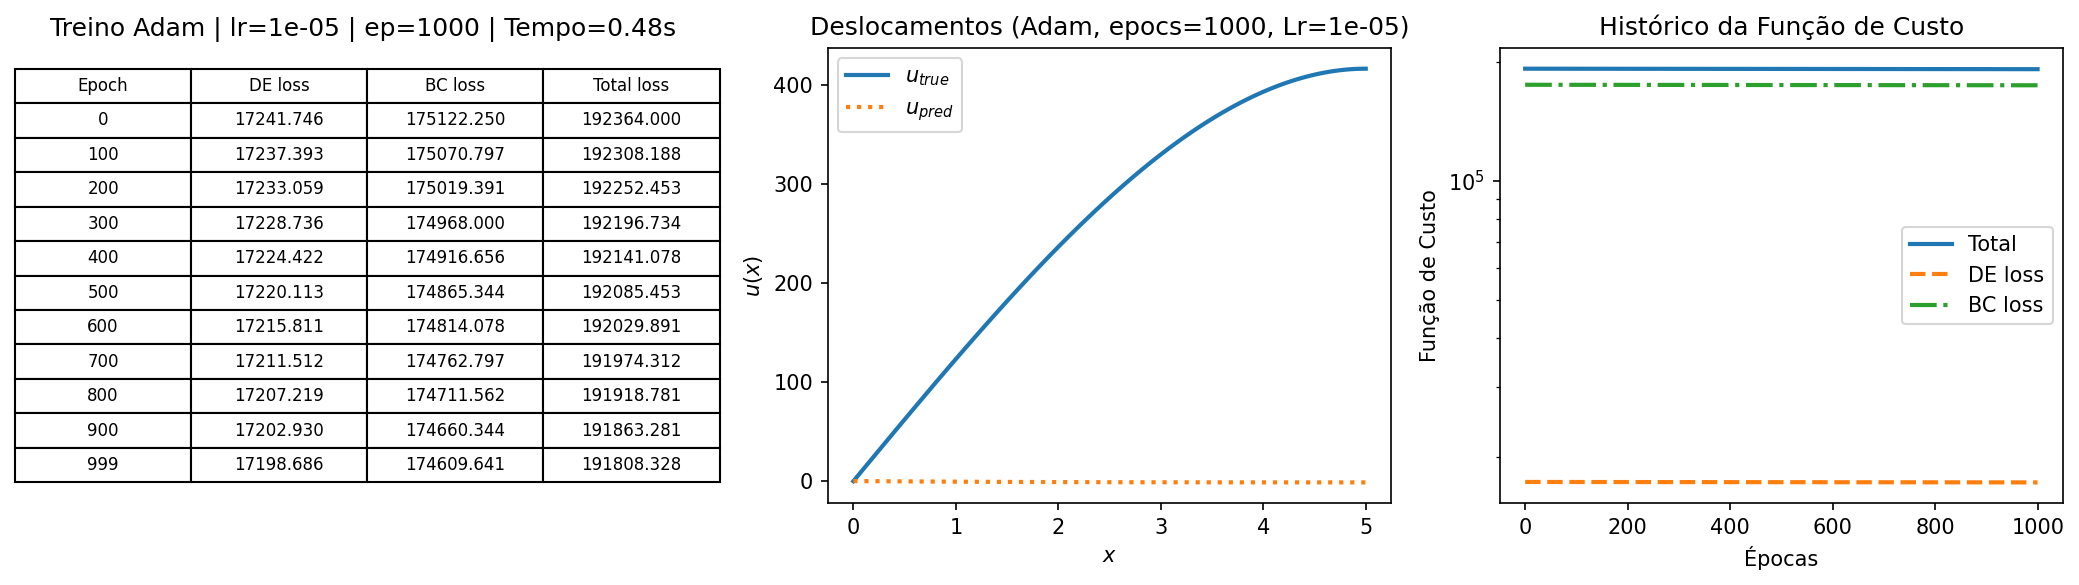

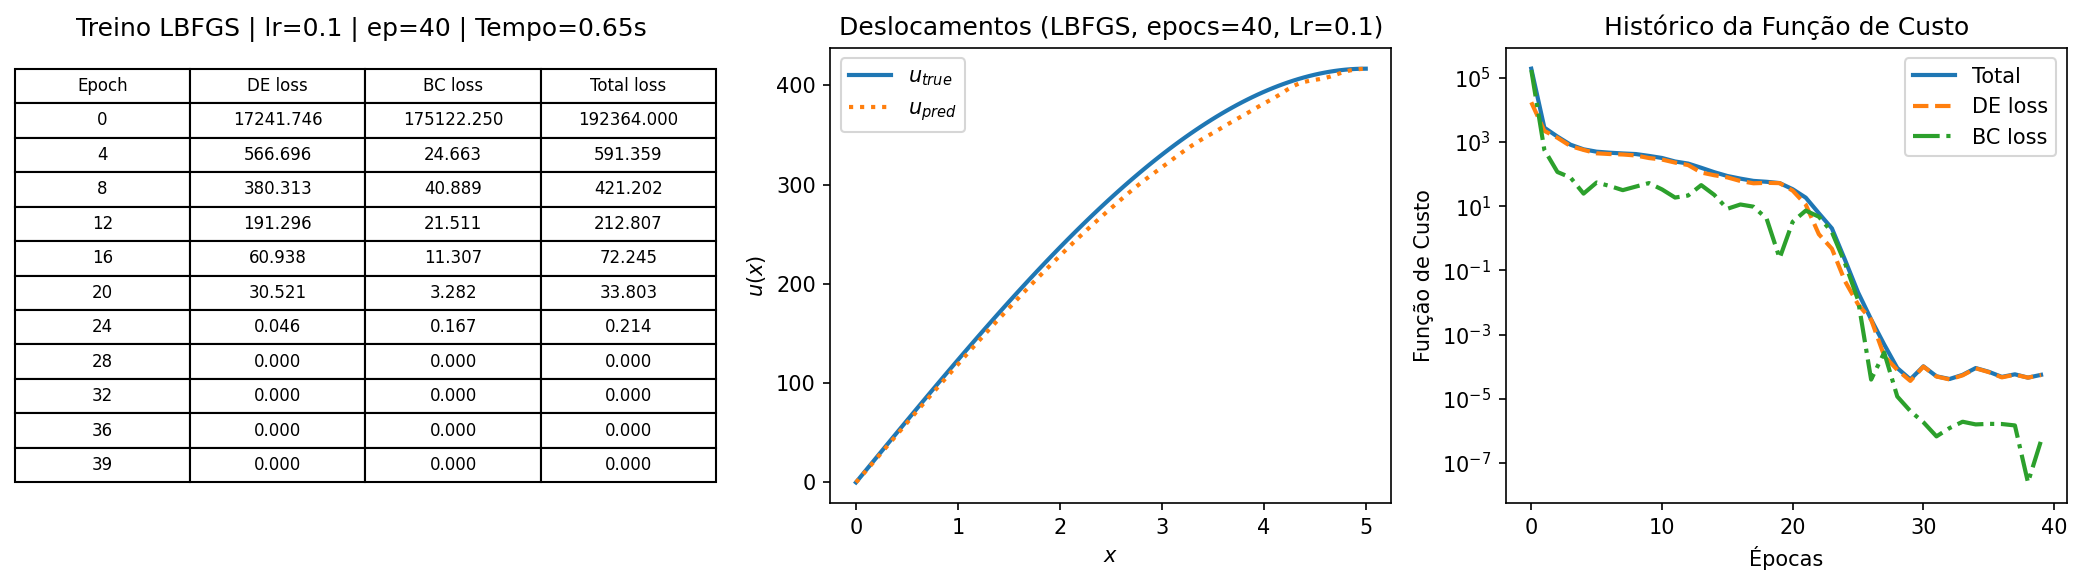

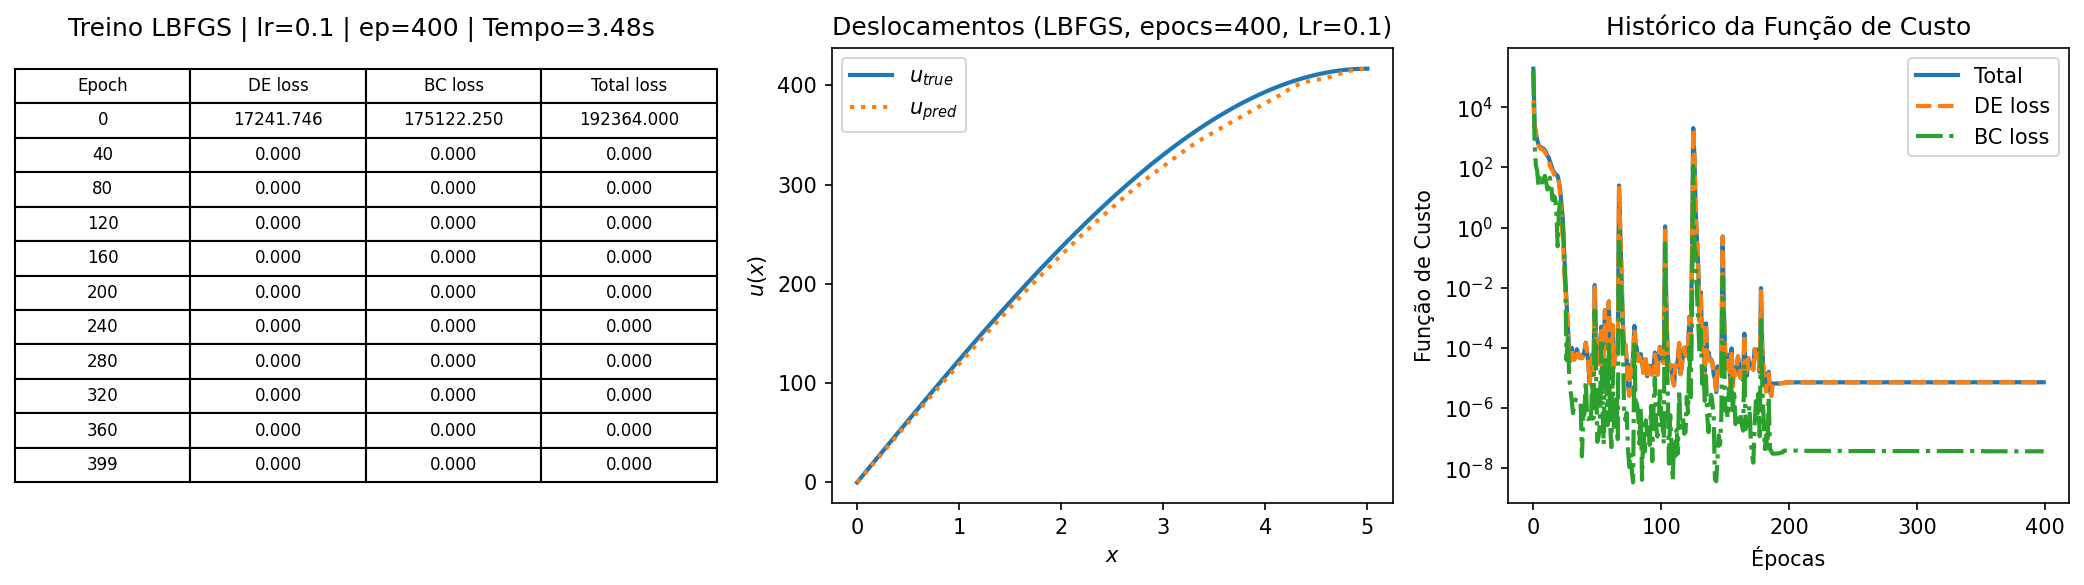

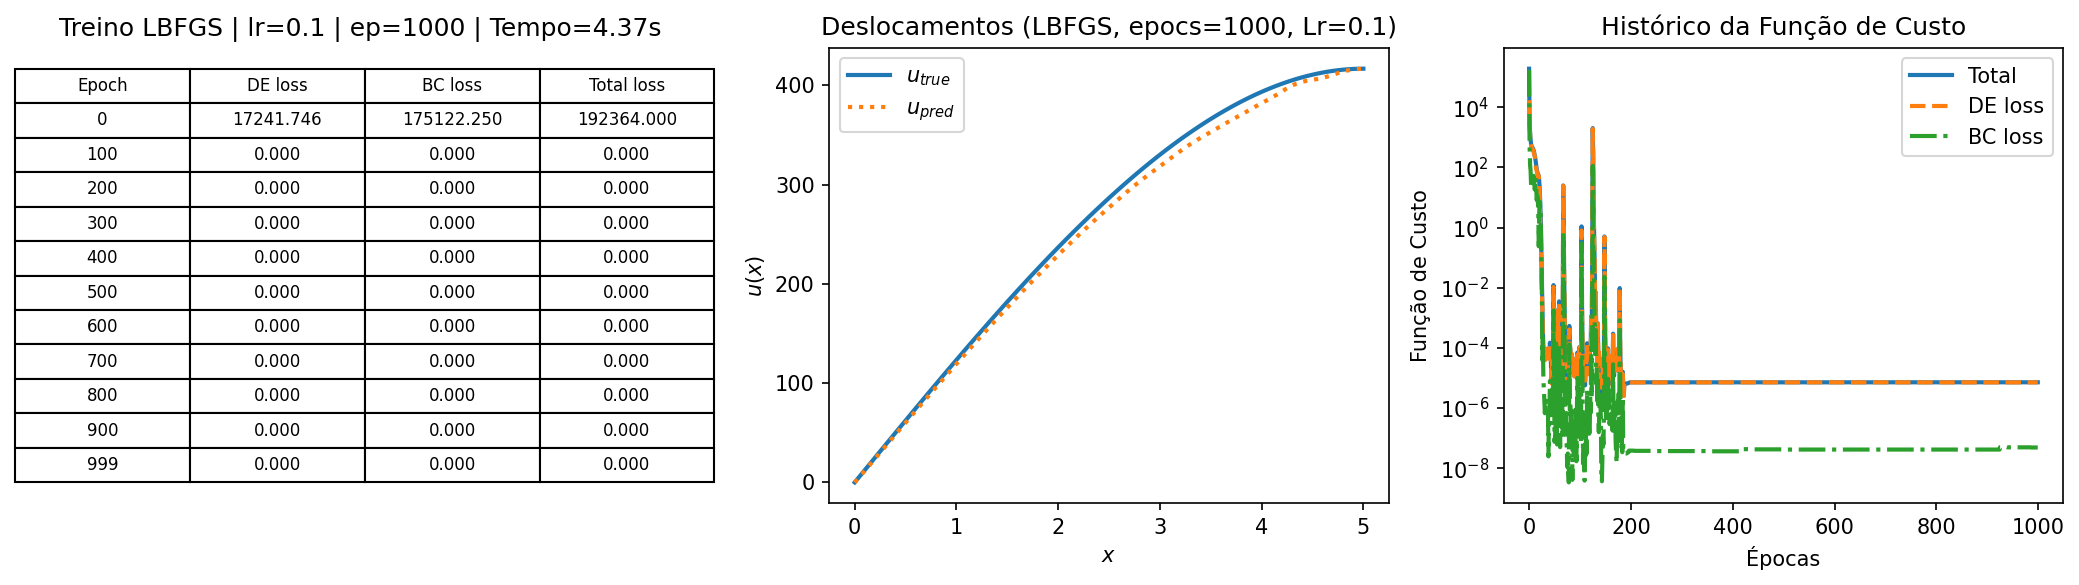

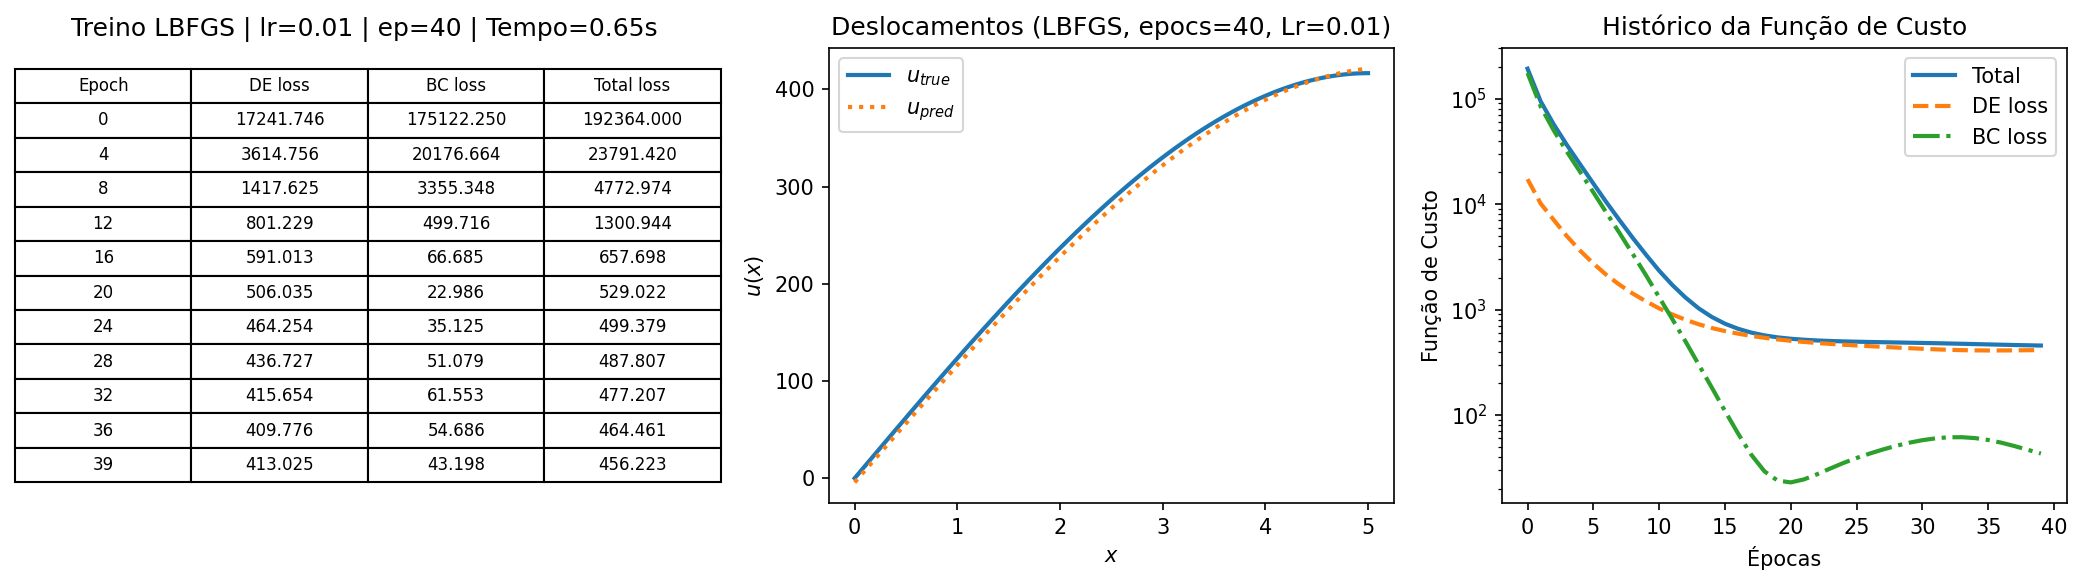

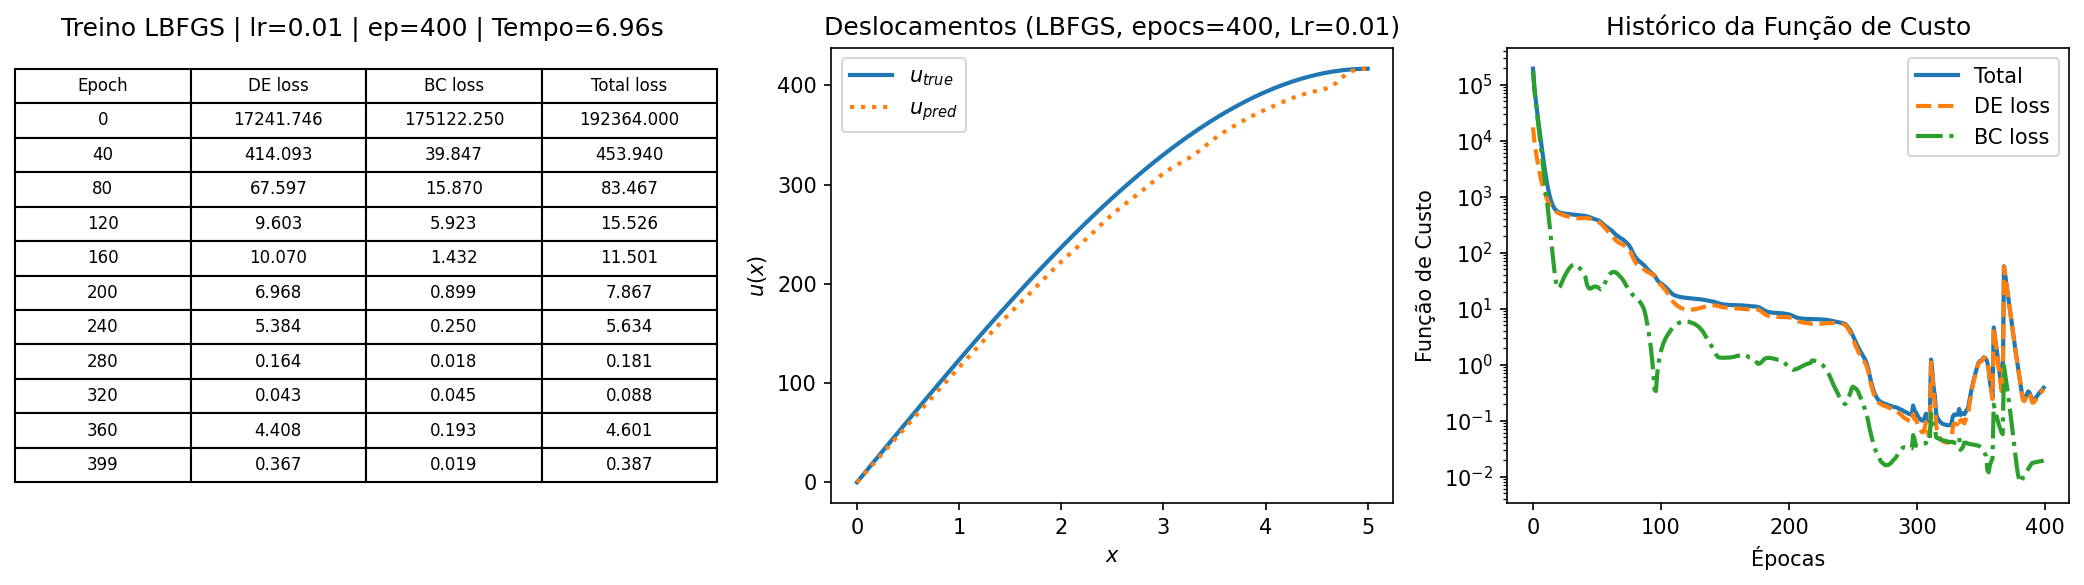

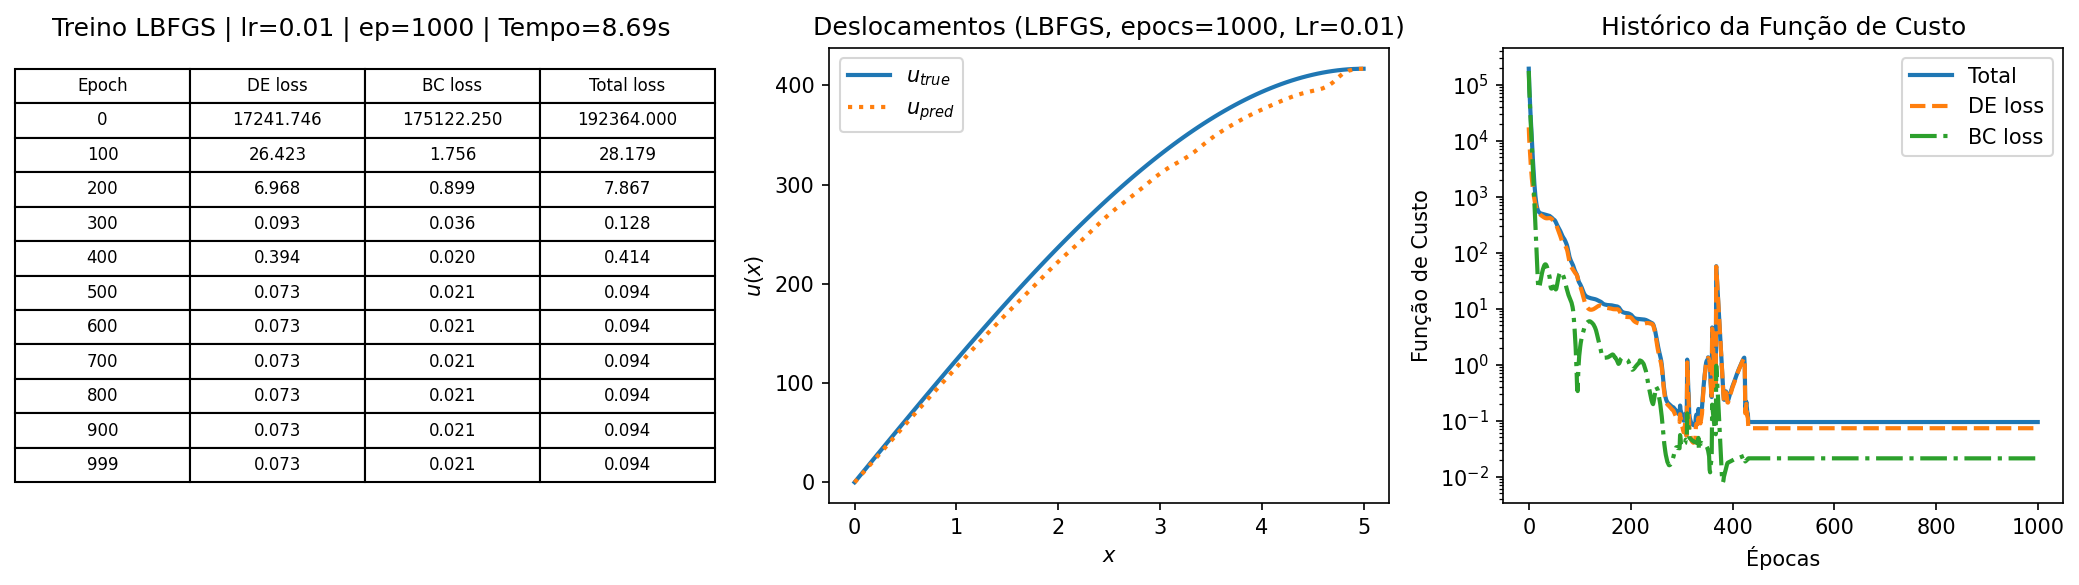

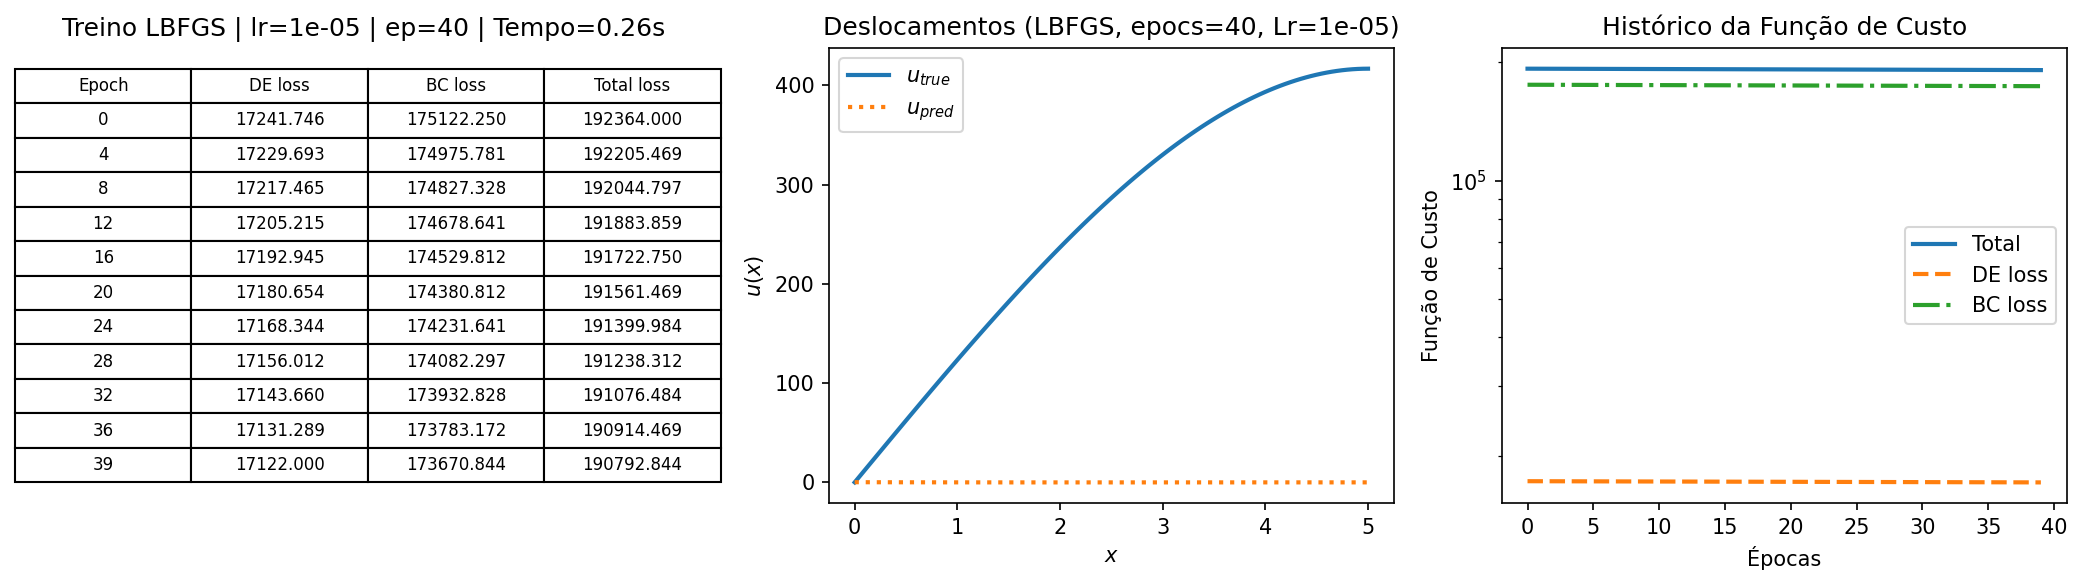

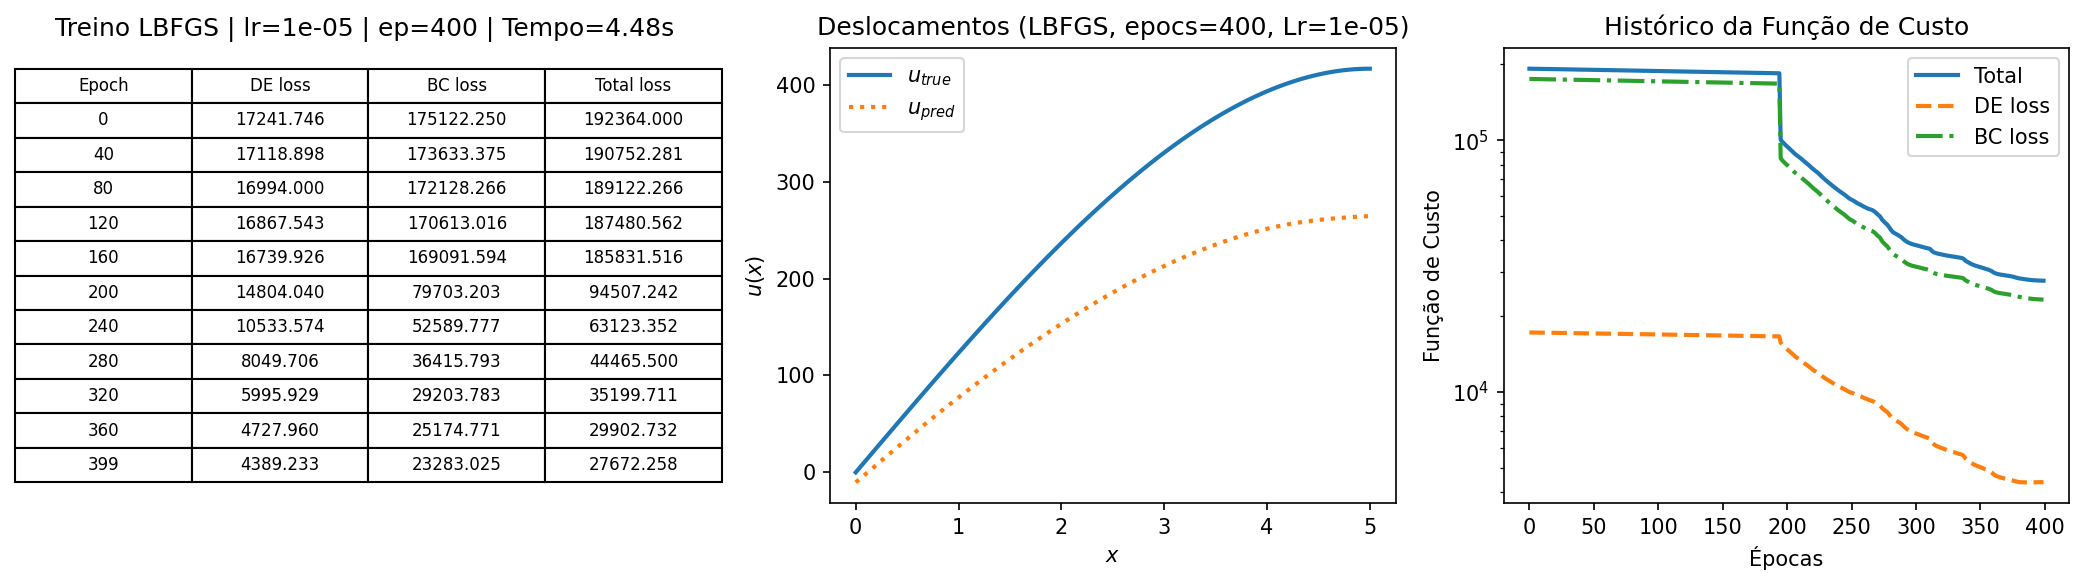

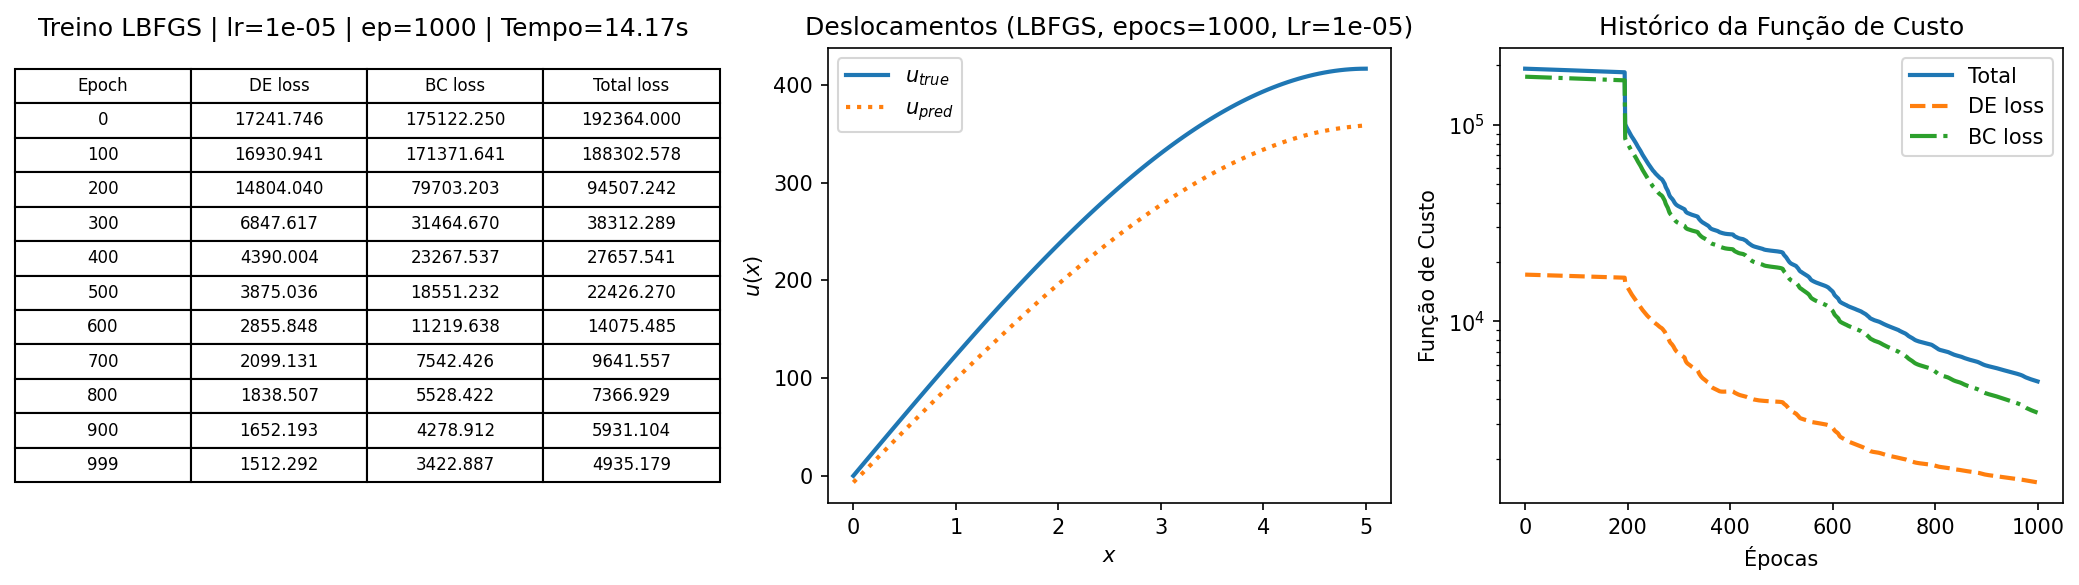

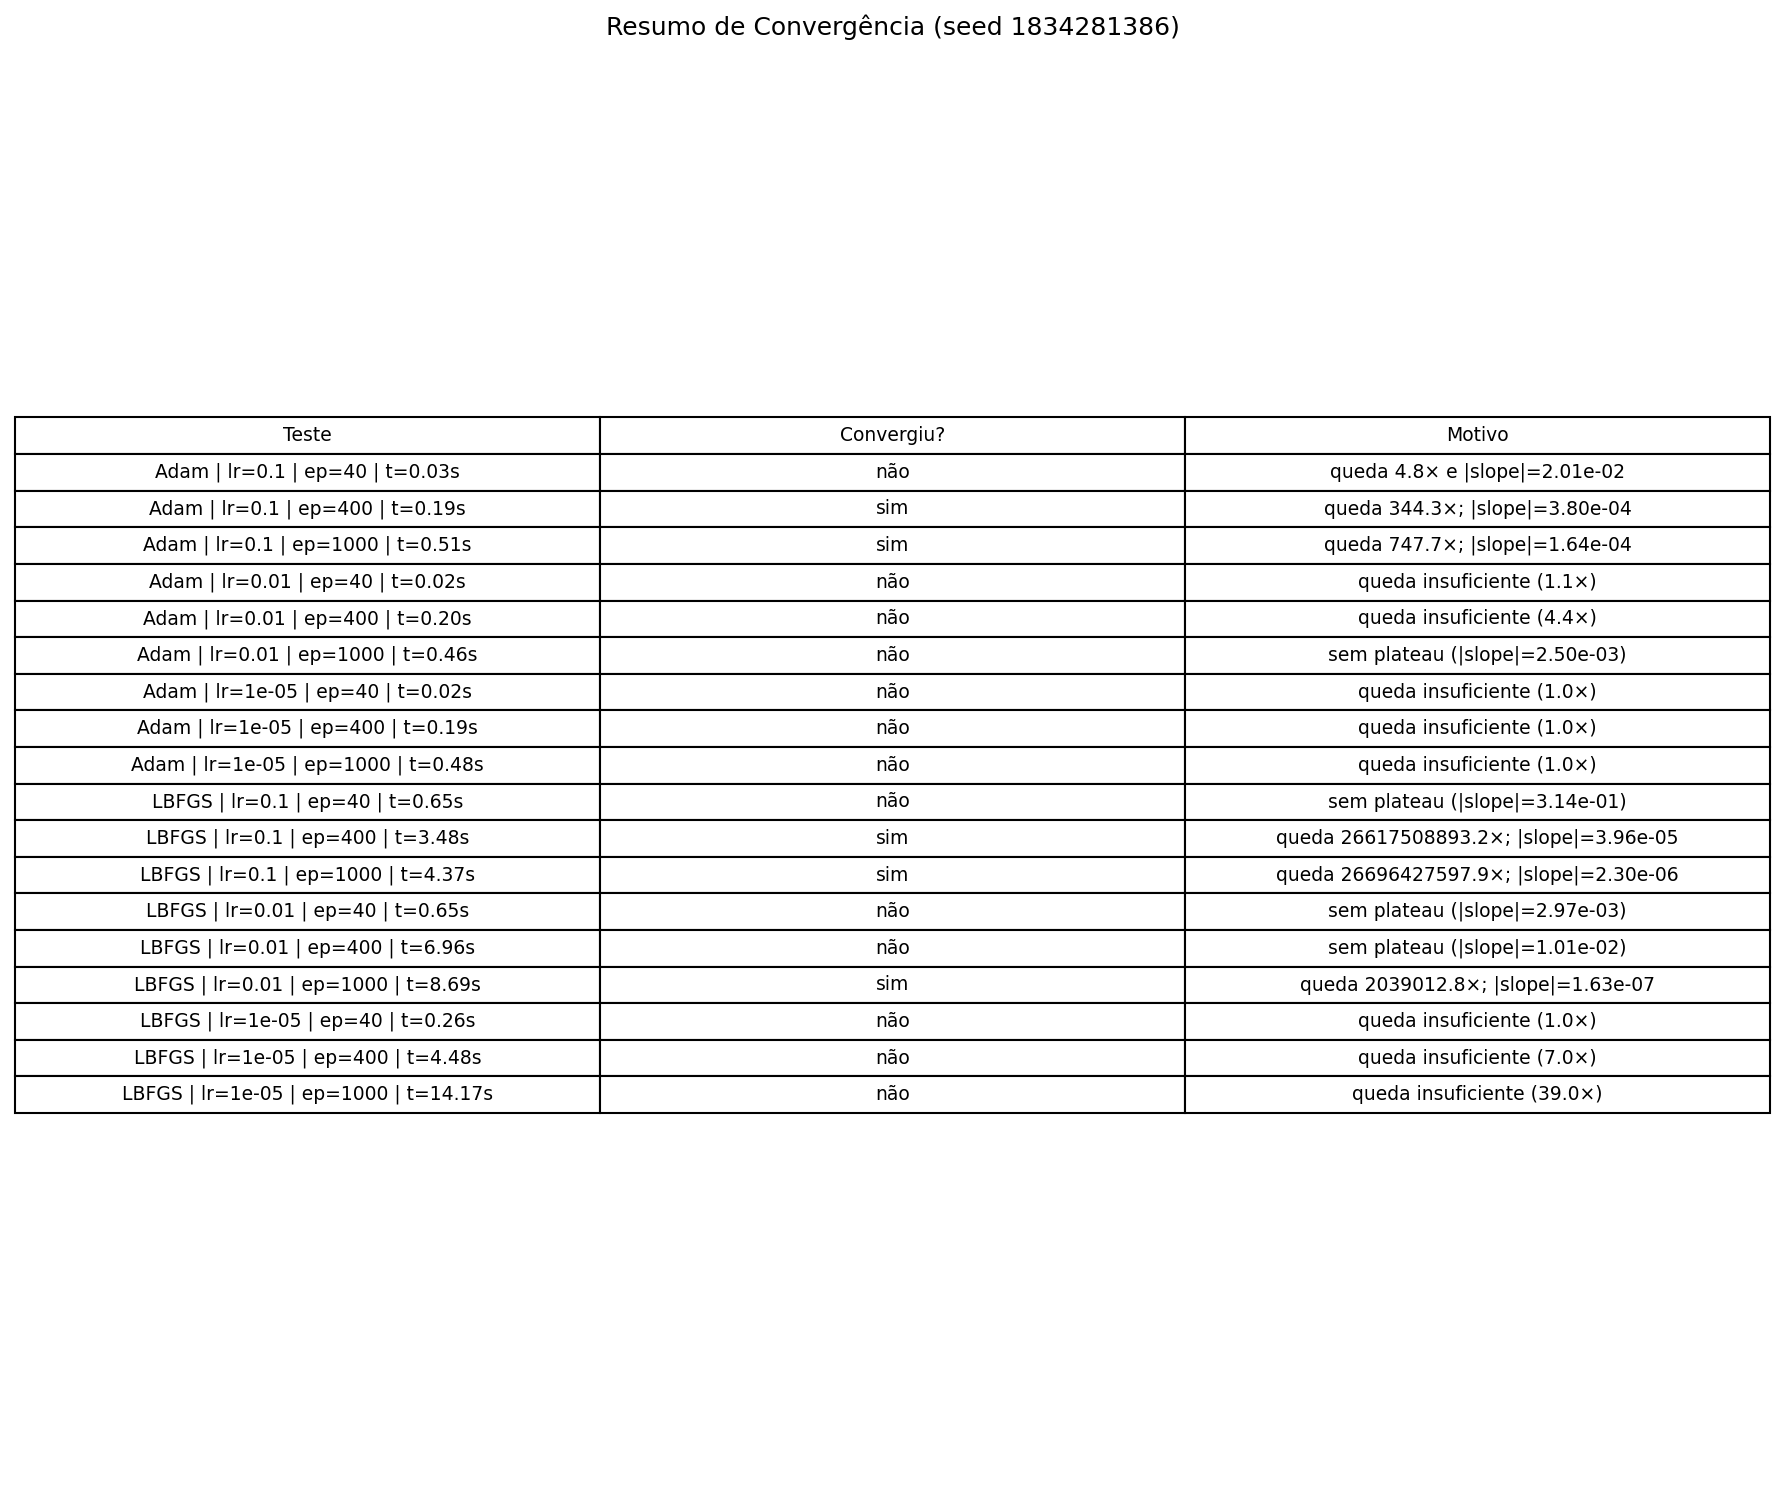

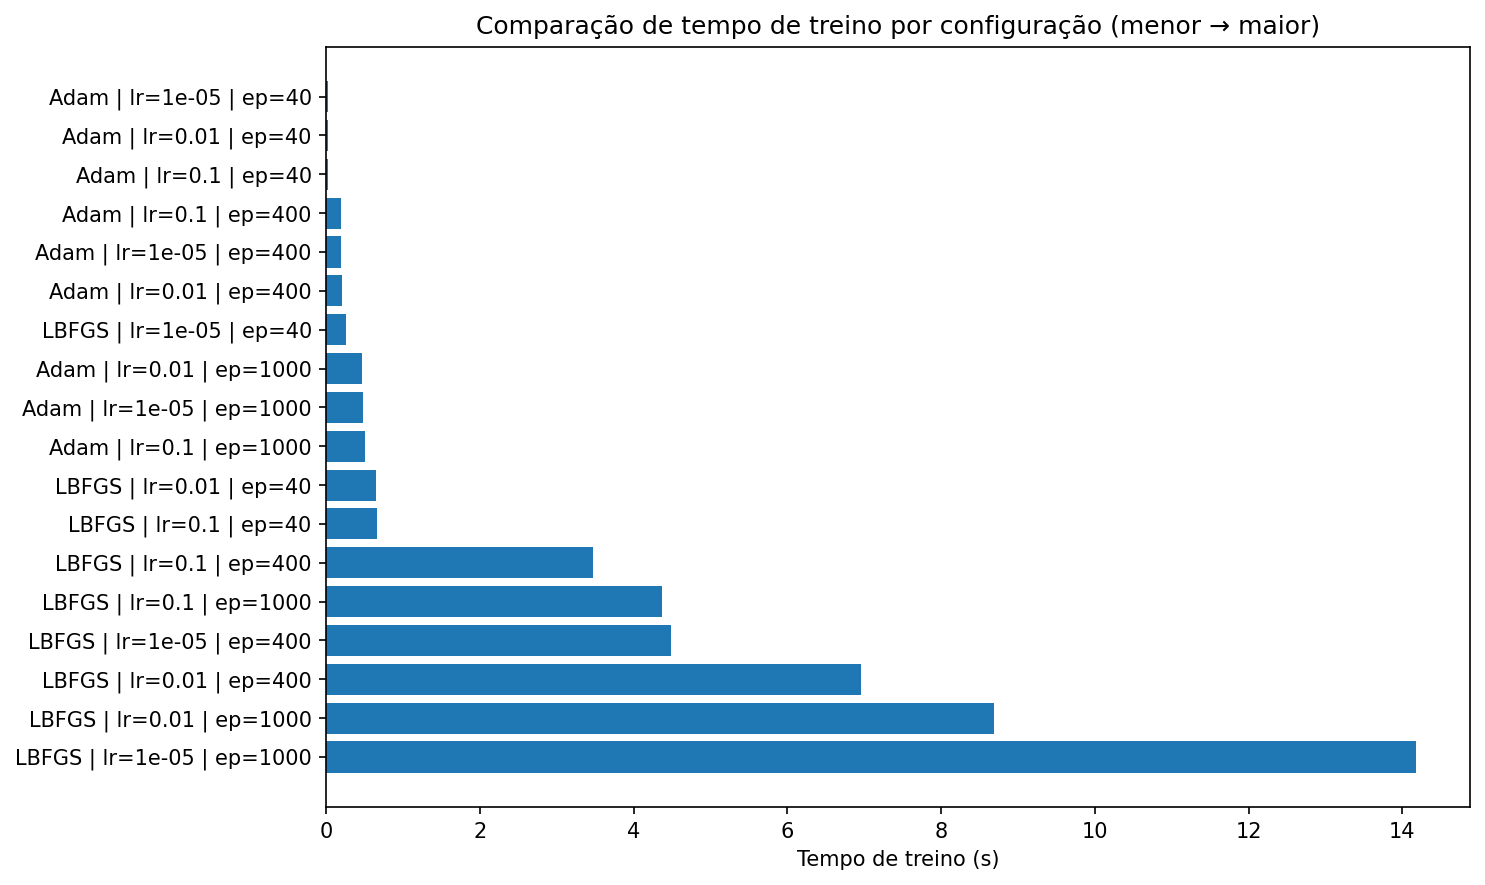

In [37]:
import torch
from torch.autograd import grad
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
import numpy as np
import time
import pandas as pd
import random, os, copy  # >>> para seed e deepcopy

dtype = torch.float
device = torch.device("cpu")

matplotlib.rcParams["figure.dpi"] = 150
rc('text', usetex=False)

# =========================================================
# >>> Funções de SEED e reprodutibilidade
# =========================================================
def set_global_seed(seed: int):
    """Fixa a seed em PyTorch/NumPy/random para reprodutibilidade."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

# >>> Gera seed aleatória uma vez e imprime (reutilize esse número para reproduzir)
USER_SEED = int.from_bytes(os.urandom(4), "little") % (2**31 - 1)
print(f"[Observação] Seed usada neste experimento: {USER_SEED}")
set_global_seed(USER_SEED)  # >>> fixando a seed número X para melhorar a comparação entre variação de parâmetros

# -----------------------------
# Utils
# -----------------------------
def generate_grid_1d(length, samples=20, initial_coordinate=0.0):
    x = torch.linspace(initial_coordinate, initial_coordinate + length, samples, requires_grad=True)
    return x.view(samples, 1)

def get_derivative(y, x, n):
    if n == 0:
        return y
    else:
        dy_dx = grad(y, x, torch.ones(x.size(0), 1, device=device), create_graph=True, retain_graph=True)[0]
        return get_derivative(dy_dx, x, n - 1)

def build_model(input_dimension, hidden_dimension, output_dimension):
    modules = []
    modules.append(torch.nn.Linear(input_dimension, hidden_dimension[0]))
    modules.append(torch.nn.Tanh())
    for i in range(len(hidden_dimension) - 1):
        modules.append(torch.nn.Linear(hidden_dimension[i], hidden_dimension[i + 1]))
        modules.append(torch.nn.Tanh())
    modules.append(torch.nn.Linear(hidden_dimension[-1], output_dimension))
    return torch.nn.Sequential(*modules)

# =========================================================
# >>> Verificador de CONVERGÊNCIA (sem mudar treino)
# =========================================================
def _lin_slope(x, y):
    x = np.asarray(x, float); y = np.asarray(y, float)
    xm, ym = x.mean(), y.mean()
    num = ((x - xm)*(y - ym)).sum()
    den = ((x - xm)**2).sum() + 1e-12
    return num / den

def avalia_convergencia(pde_hist, bc_hist, tot_hist, k=50,
                        min_drop_factor=100.0,     # queda mínima de 100×
                        max_tail_slope=2e-3):      # inclinação (log10(loss)) ~ 0
    h = np.asarray(tot_hist, float)
    p = np.asarray(pde_hist, float)
    b = np.asarray(bc_hist, float)

    # 1) finitude
    if not (np.isfinite(h).all() and np.isfinite(p).all() and np.isfinite(b).all()):
        return False, "loss não finita (inf/NaN)"

    # 2) redução suficiente
    drop = (h[0] / (h[-1] + 1e-12))
    drop_ok = drop >= min_drop_factor

    # 3) plateau no final
    kk = min(k, len(h))
    tail = np.clip(h[-kk:], 1e-16, None)
    slope = _lin_slope(np.arange(kk), np.log10(tail))
    plateau_ok = abs(slope) <= max_tail_slope

    if drop_ok and plateau_ok:
        return True, f"queda {drop:.1f}×; |slope|={abs(slope):.2e}"
    if not drop_ok and plateau_ok:
        return False, f"queda insuficiente ({drop:.1f}×)"
    if drop_ok and not plateau_ok:
        return False, f"sem plateau (|slope|={abs(slope):.2e})"
    return False, f"queda {drop:.1f}× e |slope|={abs(slope):.2e}"

# -----------------------------
# PINN
# -----------------------------
class PhysicsInformedBarModel:
    def __init__(self, E, A, L, u0, dist_load):
        self.E = E
        self.A = A
        self.L = L
        self.x = generate_grid_1d(L)
        self.u0 = u0
        self.dist_load = dist_load
        self.model = build_model(1, [64], 1)  # sua arquitetura
        self.PDE_loss_history = None
        self.ICBC_loss_history = None
        self.total_loss_history = None
        self.optimizer = None

    def get_displacements(self, x):
        return self.model(x)

    def costFunction(self, x, u_pred):
        EDP = get_derivative(self.E(x) * self.A(x) * get_derivative(u_pred, x, 1), x, 1) + self.dist_load(x)
        EDP_loss = torch.sum(EDP ** 2).view(1)
        ICBC_loss = (u_pred[0] - self.u0[0]) ** 2 + (u_pred[-1] - self.u0[1]) ** 2
        return EDP_loss, ICBC_loss

    def closure(self):
        self.optimizer.zero_grad()
        u_pred = self.get_displacements(self.x)
        PDE_loss, ICBC_loss = self.costFunction(self.x, u_pred)
        loss = PDE_loss + ICBC_loss
        loss.backward(retain_graph=True)
        return loss

    def train(self, epochs, print_every, optimizer='Adam', **kwargs):
        if optimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), **kwargs)
        elif optimizer == 'LBFGS':
            self.optimizer = torch.optim.LBFGS(self.model.parameters(), **kwargs)
        else:
            raise ValueError("optimizer deve ser 'Adam' ou 'LBFGS'.")

        self.PDE_loss_history = np.zeros(epochs, dtype=float)
        self.ICBC_loss_history = np.zeros(epochs, dtype=float)
        self.total_loss_history = np.zeros(epochs, dtype=float)

        for i in range(epochs):
            u_pred = self.get_displacements(self.x)
            PDE_loss, ICBC_loss = self.costFunction(self.x, u_pred)
            total_loss = PDE_loss + ICBC_loss

            self.PDE_loss_history[i] = PDE_loss.item()
            self.ICBC_loss_history[i] = ICBC_loss.item()
            self.total_loss_history[i] = total_loss.item()

            # modo quiet (se quiser prints, descomente)
            # if (i == 0) or (i == epochs - 1) or (isinstance(print_every, int) and i % print_every == 0):
            #     print(f"Epoch: {i}/{epochs-1}\tDE={self.PDE_loss_history[i]:.6f}\tBC={self.ICBC_loss_history[i]:.6f}\tTotal={self.total_loss_history[i]:.6f}")

            self.optimizer.step(self.closure)

# -----------------------------
# Plot: tabela + deslocamentos + histórico
# -----------------------------
def criar_historico_df(model, step, incluir_ultimo=True):
    eps = list(range(0, len(model.total_loss_history), step if step > 0 else 1))
    if incluir_ultimo and (len(model.total_loss_history) - 1) not in eps:
        eps.append(len(model.total_loss_history) - 1)  # garante última época (ex.: 999)
    linhas = []
    for ep in eps:
        linhas.append([
            ep,
            f"{model.PDE_loss_history[ep]:.3f}",
            f"{model.ICBC_loss_history[ep]:.3f}",
            f"{model.total_loss_history[ep]:.3f}",
        ])
    return pd.DataFrame(linhas, columns=["Epoch", "DE loss", "BC loss", "Total loss"])

def plot_tabela_e_graficos(x, u, u_analytic, model, optimizer, epochs, lr, historico_df, elapsed):
    fig, axes = plt.subplots(1, 3, figsize=(14, 4), gridspec_kw={'width_ratios': [1.25, 1, 1]})

    # Tabela
    axes[0].axis('off')
    axes[0].set_title(f"Treino {optimizer} | lr={lr} | ep={epochs} | Tempo={elapsed:.2f}s ")
    table = axes[0].table(cellText=historico_df.values,
                          colLabels=historico_df.columns,
                          cellLoc='center',
                          loc='center')
    table.scale(1, 1.4)
    table.auto_set_font_size(False)
    table.set_fontsize(8)

    # Deslocamentos
    titulo1 = f"Deslocamentos ({optimizer}, epocs={epochs}, Lr={lr})"
    axes[1].set_title(titulo1)
    axes[1].set_xlabel("$x$")
    axes[1].set_ylabel("$u(x)$")
    xnp = x.detach().numpy()
    unp = u.detach().numpy()
    if u_analytic is not None:
        axes[1].plot(xnp, u_analytic(xnp), linewidth=2, label=r"$u_{true}$")
    axes[1].plot(xnp, unp, linestyle=':', linewidth=2, label=r"$u_{pred}$")
    axes[1].legend()

    # Histórico
    axes[2].set_title("Histórico da Função de Custo")
    axes[2].set_xlabel("Épocas")
    axes[2].set_ylabel("Função de Custo")
    axes[2].set_yscale('log')
    axes[2].plot(model.total_loss_history, linewidth=2, label="Total")
    axes[2].plot(model.PDE_loss_history, linestyle='--', linewidth=2, label="DE loss")
    axes[2].plot(model.ICBC_loss_history, linestyle='-.', linewidth=2, label="BC loss")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

# -----------------------------
# Problema 1D
# -----------------------------
E = lambda x: 1 + 0*x
A = lambda x: 1 + 0*x
L = 5
C = 10
q = lambda x: C * x
u0 = [0.0, (C * L**3) / (3 * 1)]
solucao_analitica = lambda x: (C / (E(x) * A(x))) * ((L**2 * x / 2) - x**3 / 6)

optimizers = ['Adam', 'LBFGS']
learning_rates = [0.1, 0.01, 1e-5]
epochs_list = [40, 400, 1000]

# -----------------------------
# >>> Criação de "pesos base" para reuso
#     (todo cenário começa do MESMO ponto)
# -----------------------------
modelo_base = PhysicsInformedBarModel(E, A, L, u0, dist_load=q)
pesos_iniciais = copy.deepcopy(modelo_base.model.state_dict())  # >>> criação de pesos bases para retornar o início do treino

# -----------------------------
# Loop de experiências
# -----------------------------
resultados_treinamento = []

for optimizer in optimizers:
    for lr in learning_rates:
        for epochs in epochs_list:
            # >>> cria novo modelo e restaura os PESOS INICIAIS idênticos
            pinnModel = PhysicsInformedBarModel(E, A, L, u0, dist_load=q)
            pinnModel.model.load_state_dict(pesos_iniciais)

            print_every = max(1, epochs // 10)

            start_time = time.time()
            pinnModel.train(epochs=epochs, print_every=print_every, optimizer=optimizer, lr=lr)
            elapsed = time.time() - start_time

            # >>> validação de convergência (NÃO altera o treino)
            convergiu, motivo = avalia_convergencia(
                pinnModel.PDE_loss_history,
                pinnModel.ICBC_loss_history,
                pinnModel.total_loss_history,
                k=max(20, epochs//5),      # janela de cauda proporcional ao nº de épocas
                min_drop_factor=100.0,     # exigência de queda 100×
                max_tail_slope=2e-3        # plateau ~ horizontal em log10
            )

            resultados_treinamento.append({
                'seed': USER_SEED,                 # >>> registra a seed usada
                'optimizer': optimizer,
                'learning_rate': lr,
                'epochs': epochs,
                'tempo_segundos': float(elapsed),
                'loss_total_final': float(pinnModel.total_loss_history[-1]),
                'loss_pde_final':   float(pinnModel.PDE_loss_history[-1]),
                'loss_bc_final':    float(pinnModel.ICBC_loss_history[-1]),
                'convergiu': bool(convergiu),      # >>> flag
                'motivo': motivo                    # >>> explicação curta
            })

            # Geração dos dados e figura tripla (opcional manter)
            x_test = generate_grid_1d(L, 100)
            u_test = pinnModel.get_displacements(x_test)
            hist_df = criar_historico_df(pinnModel, step=print_every, incluir_ultimo=True)  # garante última época
            plot_tabela_e_graficos(x_test, u_test, solucao_analitica, pinnModel, optimizer, epochs, lr, hist_df, elapsed)

# -----------------------------
# Resumo (tabela dos 18 casos, na ordem executada)
# -----------------------------
resumos = []
for r in resultados_treinamento:
    teste_str = f"{r['optimizer']} | lr={r['learning_rate']} | ep={r['epochs']} | t={r['tempo_segundos']:.2f}s"
    resumos.append({
        "Teste": teste_str,
        "Convergiu?": "sim" if r["convergiu"] else "não",
        "Motivo": r["motivo"]
    })

df_resumo = pd.DataFrame(resumos)   # não ordenar: mantém a ordem de execução
# print("\nResumo de convergência (seed =", USER_SEED, ")\n")
# print(df_resumo.to_string(index=False))

# --- opcional: renderizar como imagem (tabela matplotlib) ---
fig, ax = plt.subplots(figsize=(12, 0.5*len(df_resumo)+1))
ax.axis('off')
tbl = ax.table(cellText=df_resumo.values,
               colLabels=df_resumo.columns,
               cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(9)
tbl.scale(1, 1.2)
plt.title(f"Resumo de Convergência (seed {USER_SEED})", pad=12)
plt.tight_layout()
plt.show()

# -----------------------------
# Gráfico de tempo (ordem decrescente)
# -----------------------------
df_tempo = pd.DataFrame(resultados_treinamento).sort_values(by='tempo_segundos', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(
    [f"{row.optimizer} | lr={row.learning_rate} | ep={row.epochs}"
     for _, row in df_tempo.iterrows()],
    df_tempo['tempo_segundos']
)
plt.xlabel("Tempo de treino (s)")
plt.title("Comparação de tempo de treino por configuração (menor → maior)")
plt.tight_layout()
plt.show()
